### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph


In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4366,0],
    [0.8528,0], 
    [1.1443,0],
    [1.31495,0],
    [1.56274,0],
    [1.736384,0],
    [2.0710,0], 
    [2.20665,0],
    [3.05674,0],
    [3.32804,0],
    [4.1148,0],
    [4.54888,0], 
    [4.73879,0],
    [5.07844,0],
    [6.62475,0], 
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [7.5, 3, 3, 7.5, 7.5, 6.5, 10.6, 5.6, 7.5, 4.2, 8.3, 3.3, 7.7, 9.8, 3.8]
current_speeds = [-0.8* 0.2777, -2.4* 0.2777, -3.68* 0.2777, -1* 0.2777,
                           -1.5* 0.2777, -1.9* 0.2777, -0.8* 0.2777, -0.7* 0.2777,
                           -1.6* 0.2777, -3.7* 0.2777, -1.5* 0.2777, -4.8* 0.2777,
                           -1.4* 0.2777, -1* 0.2777, -3.1* 0.2777] 

V_g_profile = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
power_applied = [633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633, 633]
# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile": V_g_profile[index],
        "PowerApplied": power_applied[index],
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

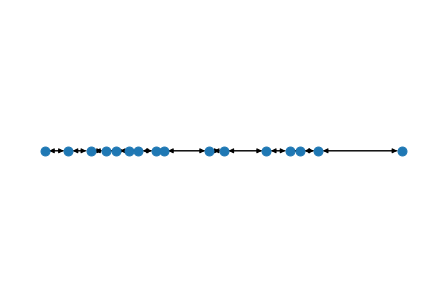

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {} m/s'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground Profile for edge {} is {} m/s'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile"]))
    print('Power applied for edge {} is {} kW'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["PowerApplied"]))

General depth for edge ('Node 0', 'Node 1') is 7.5 m
Current speed for edge ('Node 0', 'Node 1') is -0.22216000000000002 m/s
Vessel Speed To Ground Profile for edge ('Node 0', 'Node 1') is 3 m/s
Power applied for edge ('Node 0', 'Node 1') is 633 kW
General depth for edge ('Node 1', 'Node 0') is 7.5 m
Current speed for edge ('Node 1', 'Node 0') is -0.22216000000000002 m/s
Vessel Speed To Ground Profile for edge ('Node 1', 'Node 0') is 3 m/s
Power applied for edge ('Node 1', 'Node 0') is 633 kW
General depth for edge ('Node 1', 'Node 2') is 3 m
Current speed for edge ('Node 1', 'Node 2') is -0.66648 m/s
Vessel Speed To Ground Profile for edge ('Node 1', 'Node 2') is 3 m/s
Power applied for edge ('Node 1', 'Node 2') is 633 kW
General depth for edge ('Node 2', 'Node 1') is 3 m
Current speed for edge ('Node 2', 'Node 1') is -0.66648 m/s
Vessel Speed To Ground Profile for edge ('Node 2', 'Node 1') is 3 m/s
Power applied for edge ('Node 2', 'Node 1') is 633 kW
General depth for edge ('Node 2'

### Create vessel - add VesselProperties and ConsumesEnergy mixins


In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": None,  # m/s
    "v":None,
    "type": None,
    "B": 9.5,
    "L": 155,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":None, # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_tot_given_profile":True,
    "P_installed": 780, # kW  
    "P_tot_given": 200, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": True,
    "sailing_upstream":False,
    "wind_influence": False, # if consider wind influence, set to True; otherwise set to False.
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.9, 
    "C_year": 1961,
}             



### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [8]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[15].name)
path_downstream = nx.dijkstra_path(FG, nodes[15].name, nodes[0].name)

### Run simulation


In [9]:
def run_simulation(V_g_ave, path, P_tot_given, sailing_upstream,sailing_on_power):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    vessel.sailing_upstream = sailing_upstream
    vessel.P_tot_given = P_tot_given
    vessel.sailing_on_power = sailing_on_power
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

In [10]:

vessel_upstream = run_simulation(V_g_ave = None , path = path_upstream, P_tot_given = 630, sailing_upstream = True,sailing_on_power=True)

# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_upstream)
energycalculation_upstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
df_upstream
        

2.92574868927786 power2v
2.721960328310288 power2v
2.721960328310288 power2v
2.92574868927786 power2v
2.92574868927786 power2v
2.9426253824515634 power2v
3.278881307591829 power2v
2.940835636699695 power2v
2.92574868927786 power2v
2.7456047703289523 power2v
2.9082447998862166 power2v
2.7326608089241278 power2v
2.925939280564449 power2v
3.177117236969796 power2v
2.741663953383199 power2v
7.446633764596299
2.741663953383199 v4energy
2.887901971495234
2.741663953383199 v4energy
2.887901971495234
2.741663953383199 v4energy
7.446633764596299
2.741663953383199 v4energy
7.446633764596299
2.741663953383199 v4energy
6.4400752305190165
2.741663953383199 v4energy
10.559675551162593
2.741663953383199 v4energy
5.532386426613063
2.741663953383199 v4energy
7.446633764596299
2.741663953383199 v4energy
4.114643958535112
2.741663953383199 v4energy
8.25083987979759
2.741663953383199 v4energy
3.196230458067644
2.741663953383199 v4energy
7.647759334172574
2.741663953383199 v4energy
9.757029236561285
2.7416

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2022-11-18 15:28:51.000000,2022-11-18 20:05:42.847032,POINT (0 0),POINT (0.4366 0),486.526530,486.526530,780,2103.774334,5.019262e+05,4.816344e+05,...,2.390653e+07,18.918834,1.314859,1.614707e+06,1256.268349,22493.555183,2103.774334,7.446634,48602.089680,16611.847032
1,2022-11-18 20:05:42.847032,2022-11-19 00:49:24.098806,POINT (0.4366 0),POINT (0.8528 0),653.638834,653.638834,780,3112.857734,7.315216e+05,7.019478e+05,...,3.537338e+07,27.993325,1.945536,2.353320e+06,1816.166274,32610.297620,3112.857734,2.887902,46331.172068,17021.251774
2,2022-11-19 00:49:24.098806,2022-11-19 04:08:05.518538,POINT (0.8528 0),POINT (1.1443 0),653.638834,653.638834,780,2180.197092,5.123463e+05,4.916333e+05,...,2.477497e+07,19.606089,1.362623,1.648229e+06,1272.014582,22839.744732,2180.197092,2.887902,32449.631566,11921.419732
3,2022-11-19 04:08:05.518538,2022-11-19 05:56:18.445006,POINT (1.1443 0),POINT (1.31495 0),486.526530,486.526530,780,822.283761,1.961835e+05,1.882522e+05,...,9.344134e+06,7.394638,0.513927,6.311264e+05,491.026554,8791.857975,822.283761,7.446634,18996.671104,6492.926468
4,2022-11-19 05:56:18.445006,2022-11-19 08:33:26.410137,POINT (1.31495 0),POINT (1.56274 0),486.526530,486.526530,780,1193.985896,2.848655e+05,2.733491e+05,...,1.356802e+07,10.737283,0.746241,9.164184e+05,712.988397,12766.097204,1193.985896,7.446634,27583.856624,9427.965131
5,2022-11-19 08:33:26.410137,2022-11-19 10:22:55.361038,POINT (1.56274 0),POINT (1.736384 0),474.004785,474.004785,780,805.852367,1.928712e+05,1.850739e+05,...,9.157413e+06,7.246874,0.503658,6.204709e+05,482.766963,8616.173511,805.852367,6.440075,19329.961659,6568.950901
6,2022-11-19 10:22:55.361038,2022-11-19 13:32:15.724296,POINT (1.736384 0),POINT (2.071 0),303.052523,303.052523,780,799.643016,2.019325e+05,1.937688e+05,...,9.086852e+06,7.191034,0.499777,6.496211e+05,496.380857,8828.680721,799.643016,10.559676,37249.282731,11360.363258
7,2022-11-19 13:32:15.724296,2022-11-19 14:57:50.485565,POINT (2.071 0),POINT (2.20665 0),462.588321,462.588321,780,615.114393,1.476435e+05,1.416746e+05,...,6.989936e+06,5.531604,0.384446,4.749723e+05,369.068636,6586.021315,615.114393,5.532386,15100.488926,5134.761269
8,2022-11-19 14:57:50.485565,2022-11-19 23:56:54.885573,POINT (2.20665 0),POINT (3.05674 0),486.526530,486.526530,780,4096.192221,9.772845e+05,9.377751e+05,...,4.654764e+07,36.836261,2.560120,3.143945e+06,2446.040221,43796.487232,4096.192221,7.446634,94631.585928,32344.400008
9,2022-11-19 23:56:54.885573,2022-11-20 03:00:14.639863,POINT (3.05674 0),POINT (3.32804 0),628.926860,628.926860,780,1918.919815,4.509462e+05,4.327154e+05,...,2.180591e+07,17.256473,1.199325,1.450703e+06,1126.870351,20102.603984,1918.919815,4.114644,30200.977852,10999.754290


In [11]:

vessel_upstream = run_simulation(V_g_ave = 1 , path = path_upstream, P_tot_given = 630, sailing_upstream = True, sailing_on_power=False)

# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_upstream)
energycalculation_upstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
df_upstream
        

2.92574868927786 power2v
2.721960328310288 power2v
2.721960328310288 power2v
2.92574868927786 power2v
2.92574868927786 power2v
2.9426253824515634 power2v
3.278881307591829 power2v
2.940835636699695 power2v
2.92574868927786 power2v
2.7456047703289523 power2v
2.9082447998862166 power2v
2.7326608089241278 power2v
2.925939280564449 power2v
3.177117236969796 power2v
2.741663953383199 power2v
2.963823953383199 V_w
7.437244761390608
2.963823953383199 v4energy
3.408143953383199 V_w
2.823735161446885
3.408143953383199 v4energy
3.763599953383199 V_w
2.783337585838481
3.763599953383199 v4energy
3.019363953383199 V_w
7.434773938629544
3.019363953383199 v4energy
3.158213953383199 V_w
7.428379820456403
3.158213953383199 v4energy
3.269293953383199 V_w
6.413582628951984
3.269293953383199 v4energy
2.963823953383199 V_w
10.552581058239529
2.963823953383199 v4energy
2.936053953383199 V_w
5.5220325207059116
2.936053953383199 v4energy
3.1859839533831993 V_w
7.427063714711286
3.1859839533831993 v4energy
3.7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2022-11-18 15:28:52.000000,2022-11-18 20:05:43.847032,POINT (0 0),POINT (0.4366 0),670.351817,670.351817,780,3133.528133,7.377672e+05,7.079410e+05,...,3.560827e+07,28.179210,1.958455,2.373413e+06,1823.713374,32826.840723,3133.528133,7.437245,48602.089680,16611.847032
1,2022-11-18 20:05:43.847032,2022-11-19 00:49:25.098806,POINT (0.4366 0),POINT (0.8528 0),1642.837438,780.000000,780,4617.636440,1.106847e+06,1.062100e+06,...,5.247314e+07,41.525508,2.886023,3.560752e+06,2687.464408,48374.359347,4617.636440,2.823735,46331.172068,17021.251774
2,2022-11-19 00:49:25.098806,2022-11-19 04:08:06.518538,POINT (0.8528 0),POINT (1.1443 0),2461.580682,780.000000,780,3571.426726,8.560710e+05,8.214620e+05,...,4.058439e+07,32.117147,2.232142,2.753999e+06,2078.570354,37414.266377,3571.426726,2.783338,32449.631566,11921.419732
3,2022-11-19 04:08:06.518538,2022-11-19 05:56:19.445006,POINT (1.1443 0),POINT (1.31495 0),727.571559,727.571559,780,1354.229109,3.235129e+05,3.104340e+05,...,1.538897e+07,12.178319,0.846393,1.040748e+06,788.161341,14186.904145,1354.229109,7.434774,18996.671104,6492.926468
4,2022-11-19 05:56:19.445006,2022-11-19 08:33:27.410137,POINT (1.31495 0),POINT (1.56274 0),861.360033,780.000000,780,2205.030487,5.285458e+05,5.071779e+05,...,2.505716e+07,19.829411,1.378144,1.700343e+06,1283.327743,23099.899379,2205.030487,7.428380,27583.856624,9427.965131
5,2022-11-19 08:33:27.410137,2022-11-19 10:22:56.361038,POINT (1.56274 0),POINT (1.736384 0),1000.968675,780.000000,780,1581.273934,3.790314e+05,3.637080e+05,...,1.796902e+07,14.220089,0.988296,1.219352e+06,920.301430,16565.425737,1581.273934,6.413583,19329.961659,6568.950901
6,2022-11-19 10:22:56.361038,2022-11-19 13:32:16.724296,POINT (1.736384 0),POINT (2.071 0),407.817237,407.817237,780,1163.273951,2.830553e+05,2.716120e+05,...,1.321902e+07,10.461097,0.727046,9.105948e+05,701.755348,12563.358666,1163.273951,10.552581,37249.282731,11360.363258
7,2022-11-19 13:32:16.724296,2022-11-19 14:57:51.485565,POINT (2.071 0),POINT (2.20665 0),628.453345,628.453345,780,894.919719,2.103061e+05,2.018039e+05,...,1.016954e+07,8.047839,0.559325,6.765593e+05,525.599659,9375.178979,894.919719,5.522033,15100.488926,5134.761269
8,2022-11-19 14:57:51.485565,2022-11-19 23:56:55.885573,POINT (2.20665 0),POINT (3.05674 0),894.567733,780.000000,780,7631.286636,1.829219e+06,1.755268e+06,...,8.671917e+07,68.626678,4.769554,5.884638e+06,4441.408822,79945.358795,7631.286636,7.427064,94631.585928,32344.400008
9,2022-11-19 23:56:55.885573,2022-11-20 03:00:15.639863,POINT (3.05674 0),POINT (3.32804 0),2404.736035,780.000000,780,3271.756260,7.842400e+05,7.525349e+05,...,3.717905e+07,29.422269,2.044848,2.522917e+06,1904.162144,34274.918585,3271.756260,4.034518,30200.977852,10999.754290


In [12]:
fuel_upstream_ton = (df_upstream['total_diesel_consumption_C_year_ICE_mass'].sum())/1000000
fuel_upstream_ton

15.128041842059476

In [13]:
vessel_downstream = run_simulation(V_g_ave = 2.56 , path = path_downstream, P_tot_given = 700, sailing_upstream = False)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_downstream = opentnsim.energy.EnergyCalculation(FG, vessel_downstream)
energycalculation_downstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_downstream = pd.DataFrame.from_dict(energycalculation_downstream.energy_use)
df_downstream

TypeError: run_simulation() missing 1 required positional argument: 'sailing_on_power'

In [ ]:
fuel_downstream_ton = (df_downstream['total_diesel_consumption_C_year_ICE_mass'].sum())/1000000
fuel_downstream_ton